### Abstract

This notebook showcases on how to build a [GAN](https://arxiv.org/pdf/1406.2661.pdf) (Generative Adversary Network) with [the pytorch framwork](http://pytorch.org/). It is inspired and adapted from [the blog post of medium.com](https://medium.com/@devnag/generative-adversarial-networks-gans-in-50-lines-of-code-pytorch-e81b79659e3f#.sch4xgsa9).


In [164]:
# Generative Adversarial Networks (GAN) example in PyTorch.
# See related blog post at 
# https://medium.com/@devnag/generative-adversarial-networks-gans-in-50-lines-of-code-pytorch-e81b79659e3f#.sch4xgsa9
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.autograd import Variable

import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

from matplotlib.pylab import rcParams
rcParams['figure.figsize'] = 15,6
rcParams['figure.dpi'] = 100
rcParams['savefig.dpi'] = 100

In [23]:
# ##### DATA: Target data and generator input data

dtype = torch.cuda.FloatTensor
#dtype = torch.FloatTensor


def get_distribution_sampler(mu, sigma):
    return lambda n: torch.Tensor(np.random.normal(mu, sigma, (1, n)))  # Gaussian

def get_generator_input_sampler():
    return lambda m, n: torch.rand(m, n)  # Uniform-dist data into generator, _NOT_ Gaussian


In [259]:
# ##### MODELS: Generator model and discriminator model
#%time

class Generator(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(Generator, self).__init__()
        self.map1 = nn.Linear(input_size, hidden_size)
        self.map2 = nn.Linear(hidden_size, hidden_size)
        self.map3 = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        x = F.elu(self.map1(x))
        x = F.sigmoid(self.map2(x))
        return self.map3(x)

class Discriminator(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(Discriminator, self).__init__()
        self.map1 = nn.Linear(input_size, hidden_size)
        self.map2 = nn.Linear(hidden_size, hidden_size)
        self.map3 = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        x = F.elu(self.map1(x))
        x = F.elu(self.map2(x))
        return F.sigmoid(self.map3(x))

def extract(v):
    return v.data.storage().tolist()


import scipy.stats as statslib

def stats(d):
    k2, p = statslib.normaltest(d)
    return [np.mean(d), np.std(d), k2, p]


def decorate_with_diffs(data, exponent):
    mean = torch.mean(data.data, 1, keepdim=True)
    mean_broadcast = torch.mul(torch.ones(data.size()), mean.tolist()[0][0])
    diffs = torch.pow(data - Variable(mean_broadcast).cuda(), exponent)
    return torch.cat([data, diffs], 1)


In [260]:
# ### Uncomment only one of these
#(name, preprocess, d_input_func) = ("Raw data", lambda data: data, lambda x: x)
(name, preprocess, d_input_func) = ("Data and variances", lambda data: decorate_with_diffs(data, 2.0), lambda x: x * 2)

print("Using data [%s]" % (name))

Using data [Data and variances]


In [299]:
# Data params
data_mean = 4
data_stddev = 1.25

# Model params
g_input_size = 1     # Random noise dimension coming into generator, per output vector
g_hidden_size = 50   # Generator complexity
g_output_size = 1    # size of generated output vector

d_input_size = 100   # Minibatch size - cardinality of distributions
d_hidden_size = 50   # Discriminator complexity
d_output_size = 1    # Single dimension for 'real' vs. 'fake'
minibatch_size = d_input_size

d_learning_rate = 2e-4  # 2e-4
g_learning_rate = 2e-4
optim_betas = (0.9, 0.999)

num_epochs = 40000
#num_epochs = 30000

print_interval = 200

d_steps = 1  # 'k' steps in the original GAN paper. Can put the discriminator on higher training freq than generator
g_steps = 1

In [300]:
d_sampler = get_distribution_sampler(data_mean, data_stddev)
gi_sampler = get_generator_input_sampler()

G = Generator(input_size=g_input_size, hidden_size=g_hidden_size, output_size=g_output_size)
D = Discriminator(input_size=d_input_func(d_input_size), hidden_size=d_hidden_size, output_size=d_output_size)

# Binary cross entropy: http://pytorch.org/docs/nn.html#bceloss
criterion = nn.BCELoss()

d_optimizer = optim.Adam(D.parameters(), lr=d_learning_rate, betas=optim_betas)
g_optimizer = optim.Adam(G.parameters(), lr=g_learning_rate, betas=optim_betas)

Run the networks on GPU

In [301]:
G = G.cuda()
D = D.cuda()
criterion = criterion.cuda()

In [302]:
d_real_error_list = []
d_fake_error_list = []
g_error_list = []

d_real_data_stat_list = []
d_fake_data_stat_list = []

g_pvalue_threshold = 0.8

def train_GAN(num_epochs):
    '''
    '''
    for epoch in range(num_epochs):
        for d_index in range(d_steps):
            # 1. Train D on real+fake
            D.zero_grad()

            #  1A: Train D on real
            d_real_data = Variable(d_sampler(d_input_size)).cuda()
        
            d_real_decision = D(preprocess(d_real_data))
            d_real_error = criterion(d_real_decision, Variable(torch.ones(1).cuda()))  # ones = true
            # compute/store gradients, but don't change params
            d_real_error.backward()
            
            #  1B: Train D on fake
            d_gen_input = Variable(gi_sampler(minibatch_size, g_input_size)).cuda()
            d_fake_data = G(d_gen_input).detach()  # detach to avoid training G on these labels
            d_fake_decision = D(preprocess(d_fake_data.t()))
            d_fake_error = criterion(d_fake_decision, Variable(torch.zeros(1)).cuda()).cuda()  # zeros = fake
            d_fake_error.backward()
            # Only optimizes D's parameters; changes based on stored gradients from backward()
            d_optimizer.step()  
            
        for g_index in range(g_steps):
            # 2. Train G on D's response (but DO NOT train D on these labels)
            G.zero_grad()

            gen_input = Variable(gi_sampler(minibatch_size, g_input_size)).cuda()
            g_fake_data = G(gen_input)
            dg_fake_decision = D(preprocess(g_fake_data.t()))
            # we want to fool, so pretend it's all genuine
            g_error = criterion(dg_fake_decision, Variable(torch.ones(1)).cuda()) 
            
            g_error.backward()
            g_optimizer.step()  # Only optimizes G's parameters

        d_real_error_list.append(extract(d_real_error)[0])
        d_fake_error_list.append(extract(d_fake_error)[0])
        g_error_list.append(extract(g_error)[0])
        d_real_data_stat_list.append(stats(extract(d_real_data)))
        d_fake_data_stat_list.append(stats(extract(d_fake_data)))
        
        if (d_fake_data_stat_list[-1][-1] >= g_pvalue_threshold and  
            abs(d_fake_data_stat_list[-1][0] - 4) < 0.5 and 
            abs(d_fake_data_stat_list[-1][1] - 1.25) < 0.2):
            
            print('============ Early Exit =============')
            print("%s: D: %s/%s G: %s (Real: %s, Fake: %s) " % (epoch,
                                                                d_real_error_list[-1],
                                                                d_fake_error_list[-1],
                                                                g_error_list[-1],
                                                                d_real_data_stat_list[-1],
                                                                d_fake_data_stat_list[-1]))
            break
        
        if epoch % print_interval == 0:
            print("%s: D: %s/%s G: %s (Real: %s, Fake: %s) " % (epoch,
                                                                d_real_error_list[-1],
                                                                d_fake_error_list[-1],
                                                                g_error_list[-1],
                                                                d_real_data_stat_list[-1],
                                                                d_fake_data_stat_list[-1]))

In [303]:
%%time

print('Total epochs:', num_epochs)

train_GAN(num_epochs)


Total epochs: 40000
0: D: 0.629279375076294/0.6402203440666199 G: 0.7482799887657166 (Real: [3.7654325547814369, 1.2445182266183006, 1.5045744454628118, 0.47128737984887925], Fake: [-0.0082279080897569648, 0.0096290991499997612, 33.497657018622121, 5.322016296445622e-08]) 


/mnt/sdb/anaconda3/envs/pytorch/lib/python3.6/site-packages/torch/nn/functional.py:767: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])) is deprecated. Please ensure they have the same size.
  "Please ensure they have the same size.".format(target.size(), input.size()))


200: D: 0.00016118395433295518/0.6804326772689819 G: 0.7387797236442566 (Real: [4.0480458712577816, 1.1942793616015399, 0.25480340447078964, 0.88037995096222932], Fake: [-0.48420122385025022, 0.020018049624022649, 32.551371441011888, 8.5419987274739927e-08]) 
400: D: 0.0004949602298438549/0.5336754322052002 G: 0.9068742990493774 (Real: [4.0064674922823906, 1.2872234453098157, 0.6103383202519741, 0.73699869305460031], Fake: [-0.22843649849295616, 0.067353975185778597, 41.322144164331142, 1.0641685124913067e-09]) 
600: D: 0.00012601216440089047/0.3760800063610077 G: 1.1224045753479004 (Real: [4.0073548090457916, 1.283665429869959, 0.75479389137995412, 0.68564385649813686], Fake: [-0.21035829968750477, 0.19302073935732142, 28.921153672357111, 5.2462776956254578e-07]) 
800: D: 0.0004887583199888468/0.03769413009285927 G: 2.9105684757232666 (Real: [3.8820945416390895, 1.2956840777456355, 2.5753017222569934, 0.27591819251609734], Fake: [0.34165604118257759, 0.4315933579227188, 27.15696826961

6800: D: 0.5349544286727905/0.5183106660842896 G: 1.1192108392715454 (Real: [3.8324317567050459, 1.2828923900167541, 5.5732063288627689, 0.06163020643475163], Fake: [4.1393890035152436, 1.1472927960590609, 12.612524144781757, 0.0018248416325628643]) 
7000: D: 0.7394779324531555/0.6193382740020752 G: 0.6837852001190186 (Real: [3.9904266099631784, 1.1965061055691311, 7.4882393721099065, 0.02365644498246363], Fake: [3.9491008520126343, 1.2146178931542604, 20.731142854844506, 3.1498474955296727e-05]) 
7200: D: 0.6358193159103394/0.5736202001571655 G: 0.622761070728302 (Real: [4.0298774671554565, 1.0905175330866745, 3.3623372254429098, 0.18615630425184423], Fake: [4.0855411434173581, 1.220396757195191, 13.669907460208602, 0.0010755170781637715]) 
7400: D: 0.9811130166053772/0.6849104762077332 G: 0.5853396654129028 (Real: [4.0181813031435016, 1.1644794523993087, 12.133125696529317, 0.0023191307313826194], Fake: [3.9755118036270143, 1.2306637858597298, 12.103019430677103, 0.002354304991768295

13400: D: 0.30748310685157776/1.2384414672851562 G: 0.5717874765396118 (Real: [3.9877250462770464, 1.3086698607373126, 0.3113205477166987, 0.855849895570999], Fake: [4.2072968471050265, 1.0313588748427622, 32.017983182846194, 1.1152783996552359e-07]) 
13600: D: 0.8313404321670532/0.6004985570907593 G: 1.0294805765151978 (Real: [4.0134673005342485, 1.1453732412843991, 2.0934302202515522, 0.35108914615071174], Fake: [3.9710500103235247, 1.1622121646333334, 21.875893089157842, 1.7770930660927681e-05]) 
13800: D: 0.5685817003250122/0.8493385910987854 G: 0.8102425932884216 (Real: [4.0891767358779907, 1.2003351534753406, 1.1950920740388082, 0.55016005333864859], Fake: [4.0866438561677931, 1.2996700782760369, 16.0118984727583, 0.00033347280626127516]) 
14000: D: 0.4131152331829071/0.7580291032791138 G: 0.7161651849746704 (Real: [3.9092992317676543, 1.2984652993269699, 5.6423586066927438, 0.059535690653622977], Fake: [4.1600161159038542, 1.2218649546703952, 16.630016569465894, 0.00024481486534

20000: D: 2.1098721027374268/0.4904917776584625 G: 1.4560935497283936 (Real: [4.0132389974594114, 1.2225573593703121, 0.71718460314828425, 0.69865913552436387], Fake: [4.0783041191101077, 1.2063827070508666, 15.164299518263144, 0.00050946481828830544]) 
20200: D: 1.2678273916244507/0.11590175330638885 G: 1.4276180267333984 (Real: [4.1035179555416104, 1.1852645249930356, 0.2782997815474389, 0.87009759908107798], Fake: [4.0511411976814271, 1.2904589044385633, 12.14099293791174, 0.0023100260696349286]) 
20400: D: 0.4869893491268158/0.24064771831035614 G: 1.2593142986297607 (Real: [3.8110776823759078, 1.1616106940993109, 0.14925577369608589, 0.92808877612091045], Fake: [4.0834065157175061, 1.233332164513365, 14.217613552961168, 0.00081787031219421596]) 
20600: D: 1.1699793338775635/0.1828191578388214 G: 2.827533006668091 (Real: [3.9185206341743468, 1.1671377242070631, 4.8046799435189778, 0.090505924008647848], Fake: [3.8435746747255326, 1.2639393380716408, 11.093339799498798, 0.00390042444

26600: D: 0.31519952416419983/0.23687644302845 G: 1.5156232118606567 (Real: [4.0060362112522121, 1.3644897051573266, 2.1596931933544372, 0.3396476247229584], Fake: [4.6653893911838535, 1.2941041272720002, 3.5357383643913156, 0.17069632435409865]) 
============ Early Exit =============
26674: D: 0.8525641560554504/0.4772593080997467 G: 1.745361328125 (Real: [3.9188569831848143, 1.0763156218058492, 2.2114117216618618, 0.33097717594519216], Fake: [4.3709568524360654, 1.1583135049507995, 0.40422946876290361, 0.81700118443899605]) 
CPU times: user 7min 55s, sys: 8.23 s, total: 8min 4s
Wall time: 8min 16s


### Training Process Visualization

In [304]:

def get_metadata():
    
    df_metadata = pd.DataFrame()
    
    df_metadata['epoch'] = range(1, len(d_real_error_list)+1)
    df_metadata['d_real_error'] = d_real_error_list
    df_metadata['d_fake_error'] = d_fake_error_list
    df_metadata['g_error'] = g_error_list
    
    df_real_data_stat = pd.DataFrame(d_real_data_stat_list,
        columns=['d_real_data_mean', 'd_real_data_std', 'd_real_data_stats', 'd_real_data_pvalue'])
    
    df_fake_data_stat = pd.DataFrame(d_fake_data_stat_list,
        columns=['d_fake_data_mean', 'd_fake_data_std', 'd_fake_data_stats', 'd_fake_data_pvalue'])
    
    df_metadata = pd.concat([df_metadata, df_real_data_stat, df_fake_data_stat], axis=1)
    
    return df_metadata


df_metadata = get_metadata()

#df_metadata.to_csv('GAN_pytorch_metadata_epoch_40000.csv', index=False)

df_metadata.head()

,epoch,d_real_error,d_fake_error,g_error,d_real_data_mean,d_real_data_std,d_real_data_stats,d_real_data_pvalue,d_fake_data_mean,d_fake_data_std,d_fake_data_stats,d_fake_data_pvalue
0,1,0.629279,0.640220,0.748280,3.765433,1.244518,1.504574,0.471287,-0.008228,0.009629,33.497657,5.322016e-08
1,2,0.657166,0.640566,0.749013,4.051946,1.256638,2.055955,0.357730,-0.016053,0.008964,21.935387,1.725009e-05
2,3,0.640449,0.639116,0.748909,4.005394,1.143248,0.140633,0.932099,-0.021209,0.009322,18.419791,1.000445e-04
3,4,0.827049,0.640096,0.750607,4.104839,1.168614,1.582831,0.453203,-0.019558,0.010939,66.125583,4.375342e-15
4,5,0.549504,0.640139,0.750620,4.176191,1.282430,0.300081,0.860673,-0.013743,0.011224,43.432962,3.703839e-10


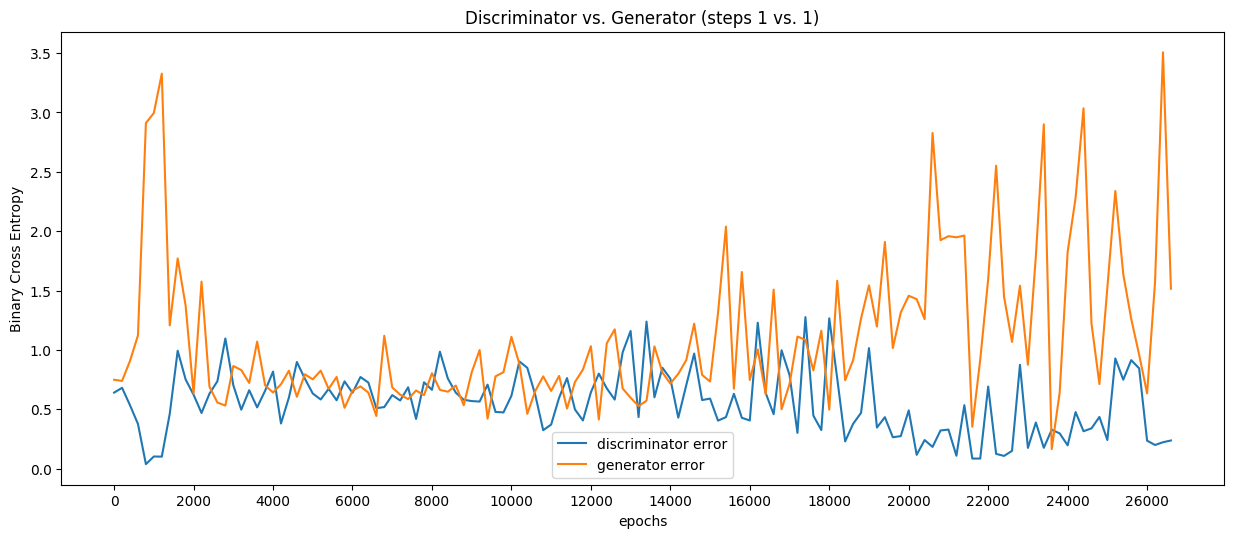

In [305]:

fig = plt.figure()
    
plot_samples = range(0, len(g_error_list), 200)

#plt.scatter(x=plot_samples, y=pd.DataFrame(g_error_list).iloc[plot_samples], linewidths=0.1)

plt.plot(plot_samples, pd.DataFrame(d_fake_error_list).iloc[plot_samples], label='discriminator error')
plt.plot(plot_samples, pd.DataFrame(g_error_list).iloc[plot_samples], label='generator error')

plt.title("Discriminator vs. Generator (steps 1 vs. 1)")

plt.xlabel('epochs')
plt.ylabel('Binary Cross Entropy')
plt.xticks(np.arange(0, len(g_error_list)+1, 2000))
plt.legend()
plt.show()

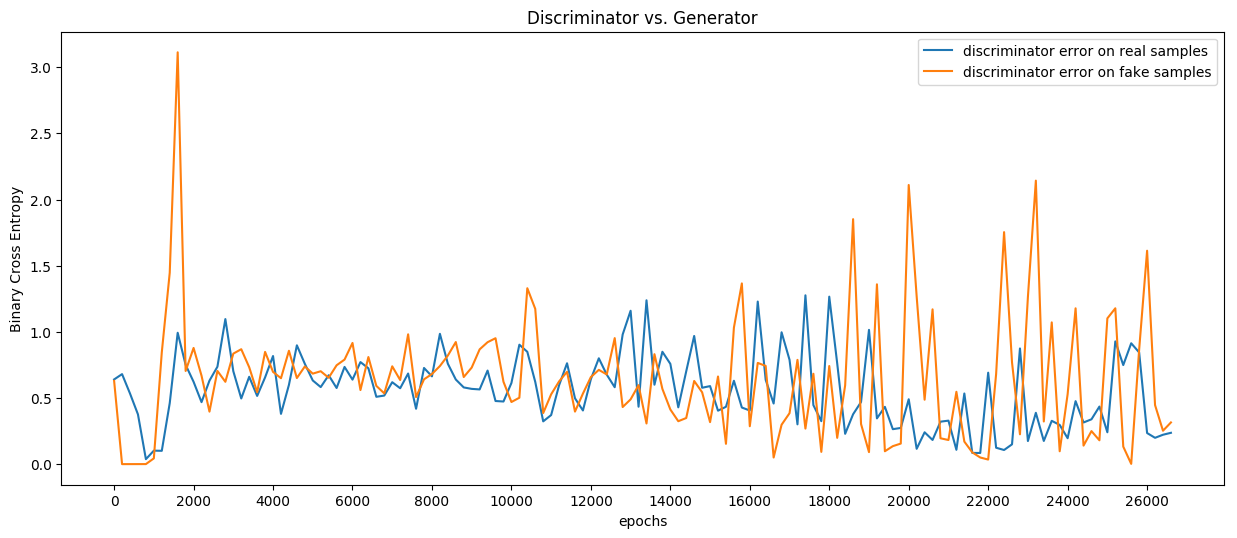

In [306]:

fig = plt.figure()
    
plot_samples = range(0, len(g_error_list), 200)

#plt.scatter(x=plot_samples, y=pd.DataFrame(g_error_list).iloc[plot_samples], linewidths=0.1)

plt.plot(plot_samples, pd.DataFrame(d_fake_error_list).iloc[plot_samples], label='discriminator error on real samples')
plt.plot(plot_samples, pd.DataFrame(d_real_error_list).iloc[plot_samples], label='discriminator error on fake samples')

plt.title("Discriminator vs. Generator")

plt.xlabel('epochs')
plt.ylabel('Binary Cross Entropy')
plt.xticks(np.arange(0, len(g_error_list)+1, 2000))
plt.legend()
plt.show()

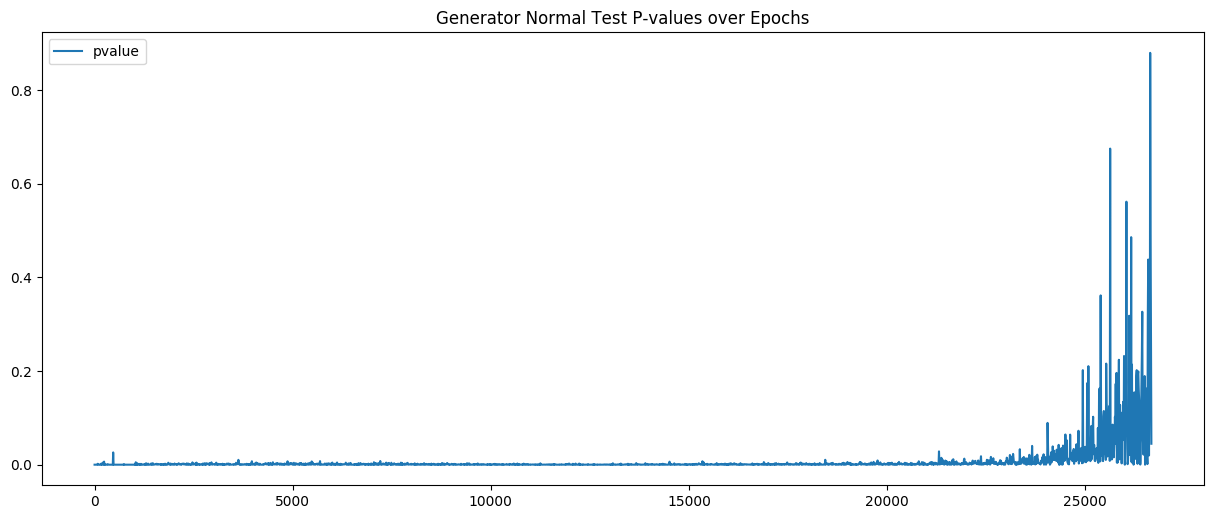

In [307]:

fig = plt.figure()
    
plot_samples = range(0, len(df_metadata)+1, 10)

plt.plot(plot_samples, df_metadata['d_fake_data_pvalue'].iloc[plot_samples], label='pvalue')

plt.title("Generator Normal Test P-values over Epochs")
plt.legend()
plt.show()

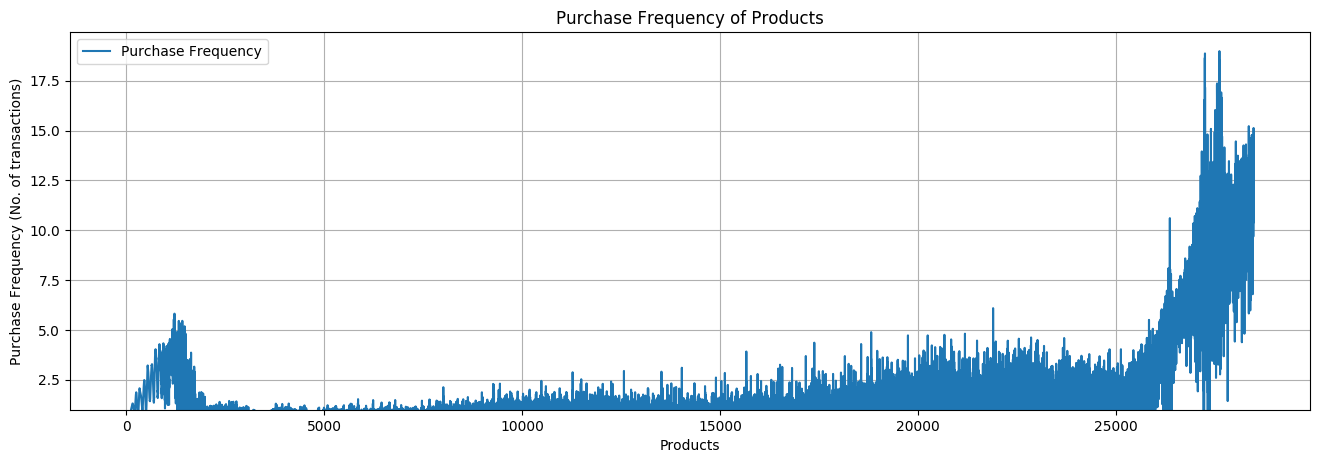

In [291]:
fig = plt.figure()

#fig.patch.set_facecolor('white')

# just to get rid of the indices, so that we could plot the result easier.
dist = pd.Series(g_error_list,
                 name='Purchase Frequency')

ax = dist.plot(kind='line', logy=False, grid=True,
               ylim=True,
               #color='r',
               figsize=(16, 5), legend=True,
               title="Purchase Frequency of Products")

#ax.axvline(65500, color='darkblue', linestyle='-')
#ax.axhline(10, color='darkgreen', linestyle='-')

plt.xlabel("Products")
plt.ylabel("Purchase Frequency (No. of transactions)")
plt.show()

### Validation

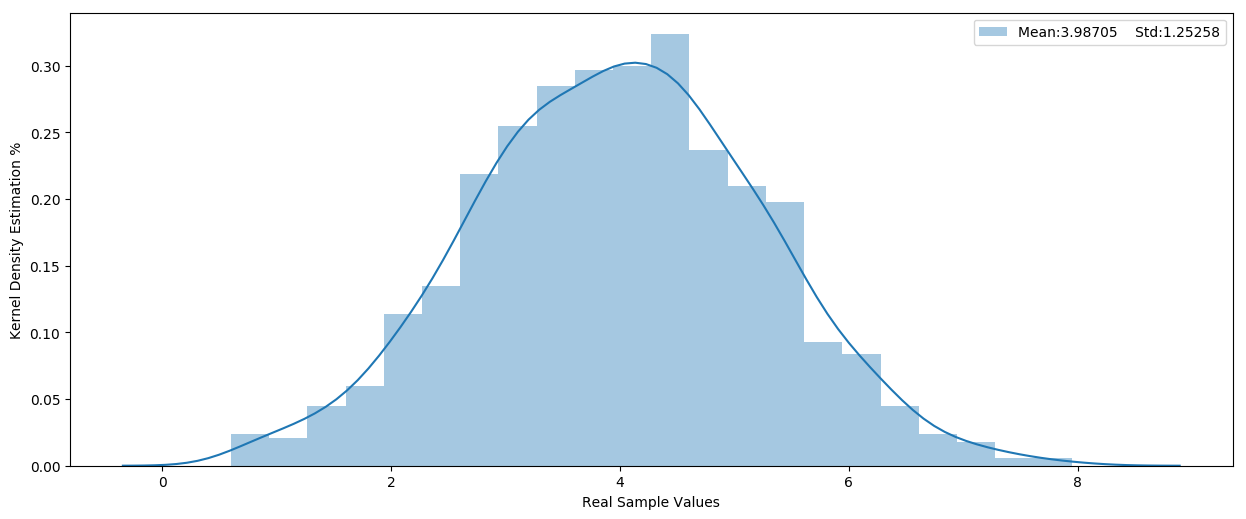

In [308]:

input_samples = d_sampler(1000).numpy()[0]

def plot_kde(input_samples, xlabel):

    legend = "Mean:" + str(input_samples.mean()) + \
             "    Std:" + str(input_samples.std())

    ax = sns.distplot(input_samples, kde=True, label=legend, axlabel=xlabel)
    ax.set_ylabel("Kernel Density Estimation %")
    _ = ax.legend()

    
plot_kde(input_samples, 'Real Sample Values')

Text(0,0.5,'count')

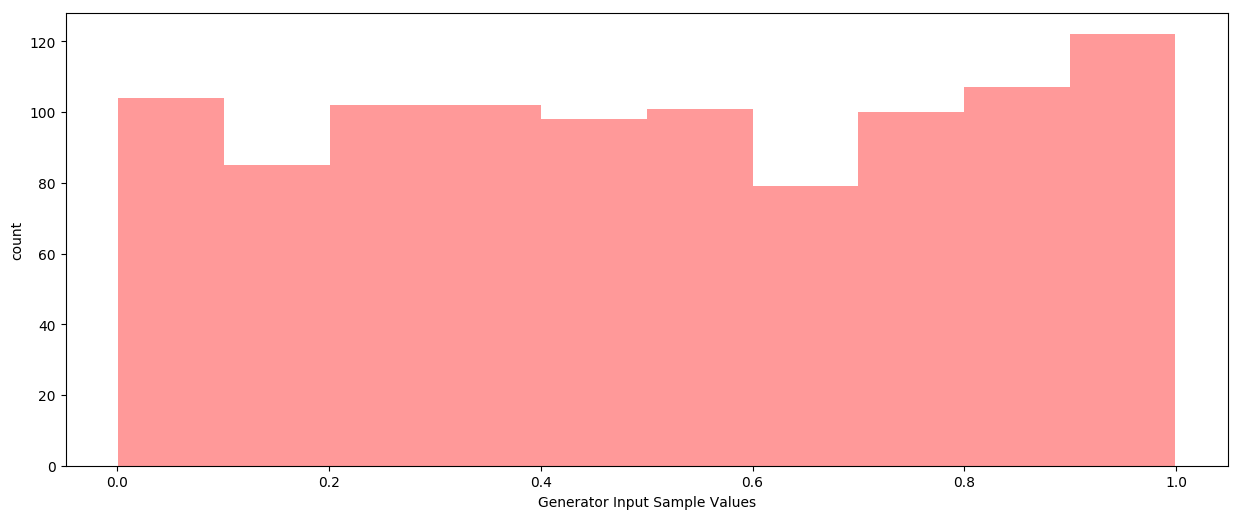

In [309]:
generator_input_samples = gi_sampler(1000, g_input_size)


ax = sns.distplot(generator_input_samples.numpy(), hist=True, kde=False, color='r')
ax.set_xlabel('Generator Input Sample Values')
ax.set_ylabel('count')


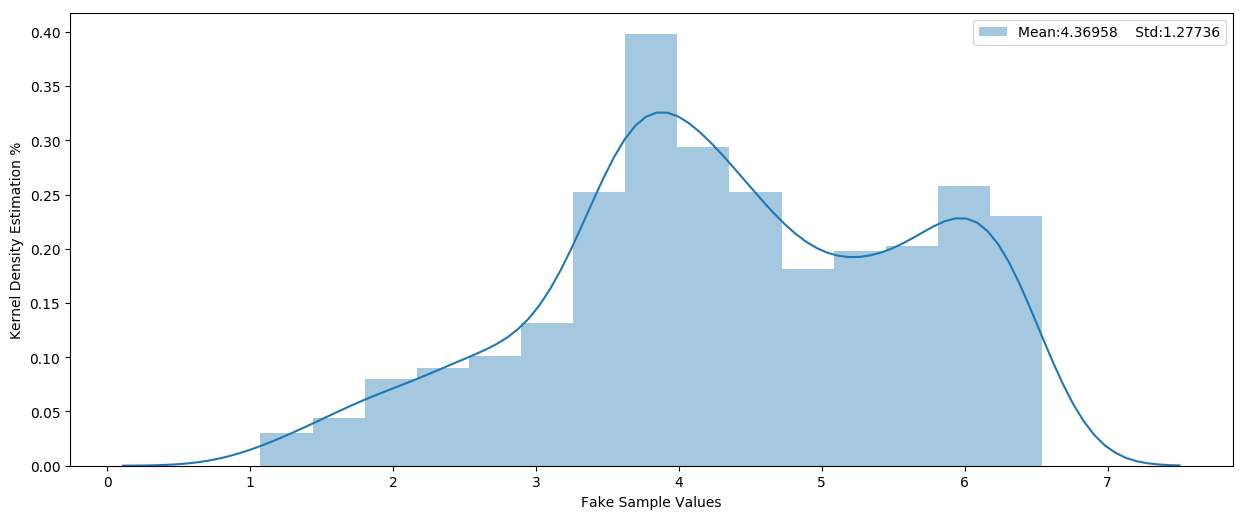

In [310]:
 
gen_input = Variable(generator_input_samples).cuda()

g_fake_data = G(gen_input).t().data.cpu().numpy()

plot_kde(g_fake_data, xlabel='Fake Sample Values')

#dg_fake_decision = D(preprocess(g_fake_data.t()))
            
            